In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from parse_log import parse_log

In [2]:
_, market_data, trade_history = parse_log("logs/empty_submission.log")

In [3]:
kelp_data = market_data[market_data["product"] == "KELP"]

In [4]:
kelp_data['timestamp'].value_counts().value_counts()

count
1    2000
Name: count, dtype: int64

In [5]:
def calc_mm_mid(row, mm_threshold):
    bids = []
    asks = []
    for i in range(1, 4):
        bid_vol = row[f'bid_volume_{i}']
        bid_price = row[f'bid_price_{i}']
        if bid_vol >= mm_threshold:
            bids.append((bid_price, bid_vol))

        ask_vol = row[f'ask_volume_{i}']
        ask_price = row[f'ask_price_{i}']
        if ask_vol >= mm_threshold:
            asks.append((ask_price, ask_vol))
    
    best_bid, best_bid_vol = max(bids) if bids else (None, None)
    best_ask, best_ask_vol = min(asks) if asks else (None, None)

    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None


kelp_data['mm_price'] = kelp_data.apply(lambda row: calc_mm_mid(row, 15), axis=1)

/var/folders/9p/y7yhf54d2yd5cdpt7hc80f2h0000gn/T/ipykernel_45852/2534273862.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kelp_data['mm_price'] = kelp_data.apply(lambda row: calc_mm_mid(row, 15), axis=1)


In [16]:
return_windows = [1, 2, 5, 10, 15, 20, 30, 50, 100]

px.line(x=kelp_data['timestamp'], y=kelp_data['mm_price'].pct_change(fill_method=None))

/var/folders/9p/y7yhf54d2yd5cdpt7hc80f2h0000gn/T/ipykernel_45852/636449657.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



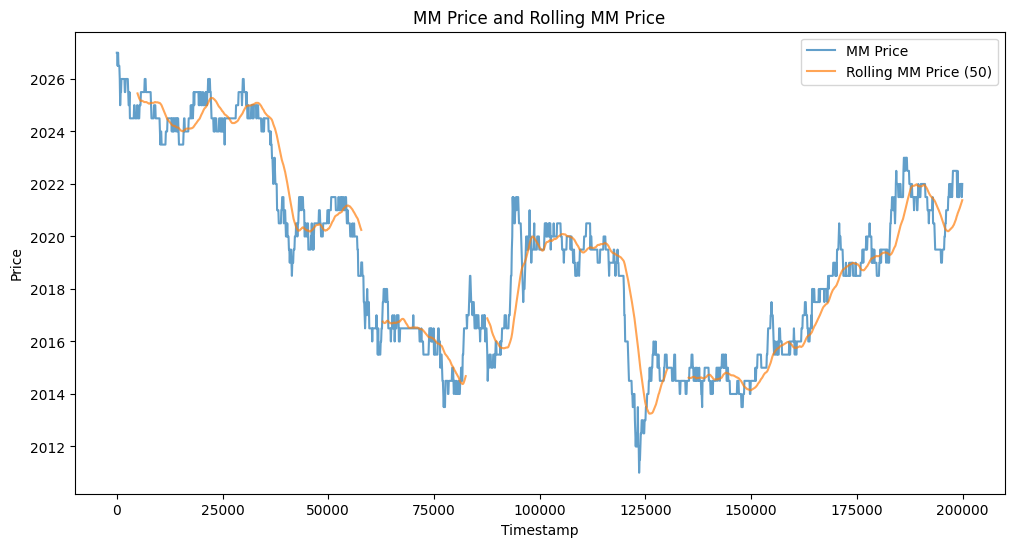

In [19]:
kelp_data['rolling_mm_price'] = kelp_data['mm_price'].rolling(window=50).mean()

plt.figure(figsize=(12, 6))
plt.plot(kelp_data['timestamp'], kelp_data['mm_price'], label='MM Price', alpha=0.7)
plt.plot(kelp_data['timestamp'], kelp_data['rolling_mm_price'], label='Rolling MM Price (50)', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('MM Price and Rolling MM Price')
plt.legend()
plt.show()

In [25]:
return_windows = [1, 2, 5, 10, 15, 20, 30, 50, 100]
kelp_returns = pd.DataFrame()

for i in return_windows:
    kelp_returns[f'growth_past_{i}'] = kelp_data['mm_price'] / kelp_data['mm_price'].shift(i)
    kelp_returns[f'growth_future_{i}'] = kelp_data['mm_price'].shift(-i) / kelp_data['mm_price']

    kelp_returns[f'pct_past_{i}'] = kelp_returns[f'growth_past_{i}'] - 1
    kelp_returns[f'pct_future_{i}'] = kelp_returns[f'growth_future_{i}'] - 1

    kelp_returns[f'log_past_{i}'] = np.log(kelp_returns[f'growth_past_{i}'])
    kelp_returns[f'log_future_{i}'] = np.log(kelp_returns[f'growth_future_{i}'])

In [37]:
kelp_returns['growth_past_1'].values.reshape(-1, 1)

(2000, 1)

### model selection

Return Window: 1
beta_1 = -0.17035491293272287
slope coefficient = 0.0
Train R-squared: 0.029135212344305605
Train MSE: 2.3697292260199704e-08
Test R-squared: 0.05819639996125825
Test MSE: 2.9737497419681026e-08

Return Window: 2
beta_1 = -0.08723141662434283
slope coefficient = 0.0
Train R-squared: 0.007723437057543081
Train MSE: 3.99602912027023e-08
Test R-squared: -0.007429285758301596
Test MSE: 4.9383859340661516e-08

Return Window: 5
beta_1 = -0.01865365238327139
slope coefficient = 0.0
Train R-squared: 9.593933038853919e-05
Train MSE: 9.36071336062037e-08
Test R-squared: 0.0007320983838238204
Test MSE: 8.081962014111954e-08

Return Window: 10
beta_1 = -0.0466934566433858
slope coefficient = 0.0
Train R-squared: 0.001574257825196157
Train MSE: 1.8129193096653105e-07
Test R-squared: 0.007229168062758751
Test MSE: 1.6688077021881226e-07

Return Window: 15
beta_1 = -0.06125709978187386
slope coefficient = 0.0
Train R-squared: 0.003502045888206129
Train MSE: 2.692974289447449e-07
Test

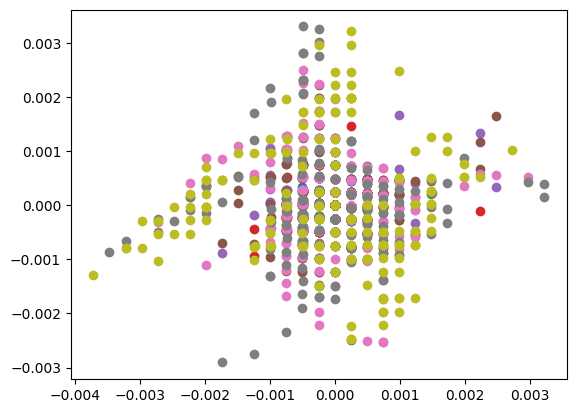

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

# Perform train-test split
train_data, test_data = train_test_split(kelp_returns, test_size=0.1, random_state=42)

# Iterate over each iteration count
for iterations in return_windows:
    # Prepare the feature and target columns
    train_data = train_data.dropna(subset=[f'pct_past_{iterations}', f'pct_future_{iterations}'])
    test_data = test_data.dropna(subset=[f'pct_past_{iterations}', f'pct_future_{iterations}'])

    X_train = train_data[f'pct_past_{iterations}'].values.reshape(-1, 1)
    y_train = train_data[f'pct_future_{iterations}']
    X_test = test_data[f'pct_past_{iterations}'].values.reshape(-1, 1)
    y_test = test_data[f'pct_future_{iterations}']

    # Create and train the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Make predictions on train and test data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    plt.scatter(X_test.reshape(-1), test_predictions - y_test)

    # Calculate R-squared and MSE for train and test data
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Print the results
    print(f"Return Window: {iterations}")
    print(f"beta_1 = {model.coef_[0]}")
    print(f'slope coefficient = {model.intercept_}')
    print(f"Train R-squared: {train_r2}")
    print(f"Train MSE: {train_mse}")
    print(f"Test R-squared: {test_r2}")
    print(f"Test MSE: {test_mse}")
    print()
    # break

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm

# Perform train-test split
train_data, test_data = train_test_split(kelp_returns, test_size=0.2, random_state=42)

# Iterate over each iteration count
for iterations in return_windows:
    # Prepare the feature and target columns
    train_data[[f'log_past_{iterations}', f'log_future_{iterations}']] = train_data[[f'log_past_{iterations}', f'log_future_{iterations}']].dropna()
    test_data[[f'log_past_{iterations}', f'log_future_{iterations}']] = test_data[[f'log_past_{iterations}', f'log_future_{iterations}']].dropna()
    X_train = train_data[f'log_past_{iterations}'].dropna().values.reshape(-1, 1)
    y_train = train_data[f'log_future_{iterations}'].dropna()
    X_test = test_data[f'log_past_{iterations}'].dropna().values.reshape(-1, 1)
    y_test = test_data[f'log_future_{iterations}'].dropna()

    # Create and train the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Make predictions on train and test data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate R-squared and MSE for train and test data
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Print the results
    print(f"Return Window: {iterations}")
    print(f"beta_1 = {model.coef_[0]}")
    print(f'slope coefficient = {model.intercept_}')
    print(f"Train R-squared: {train_r2}")
    print(f"Train MSE: {train_mse}")
    print(f"Test R-squared: {test_r2}")
    print(f"Test MSE: {test_mse}")
    print()

Return Window: 1
beta_1 = -0.16045494654303896
slope coefficient = 0.0
Train R-squared: 0.02592294696600561
Train MSE: 2.4107705506887814e-08
Test R-squared: 0.05286588950185789
Test MSE: 2.5136417638685995e-08

Return Window: 2
beta_1 = -0.09549587498918367
slope coefficient = 0.0
Train R-squared: 0.00935005891155094
Train MSE: 4.051068397113922e-08
Test R-squared: -0.00928847388772902
Test MSE: 4.222670685146958e-08

Return Window: 5
beta_1 = -0.02795940296736386
slope coefficient = 0.0
Train R-squared: 0.0007187125136571826
Train MSE: 9.403480224367295e-08
Test R-squared: -0.004146567996995643
Test MSE: 8.675128368767839e-08

Return Window: 10
beta_1 = -0.022971064543486616
slope coefficient = 0.0
Train R-squared: 0.00010312330816175663
Train MSE: 1.8505059844970594e-07
Test R-squared: 0.0032619446022461585
Test MSE: 1.658000340858875e-07

Return Window: 15
beta_1 = -0.04025402419231071
slope coefficient = 0.0
Train R-squared: 0.0015838038188303871
Train MSE: 2.741739054530781e-07
T

cannot use growth returns without slope intercept, would have to use slope intercept in that case since mean would be approx 1
- this is also clearly evidenced by the clearly low and inconsistent test r

In [50]:
model.coef_
# model.intercept_

array([0.01010188])

### actual model training

In [133]:
iterations = 1

prod_data = kelp_returns[[f'pct_past_{iterations}', f'pct_future_{iterations}']].dropna()

X = prod_data[f'pct_past_{iterations}'].values.reshape(-1, 1)
y = prod_data[f'pct_future_{iterations}']

# Create and train the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Make predictions on train and test data
yhat = model.predict(X)

# Calculate R-squared and MSE for train and test data
r2 = r2_score(y, yhat)
mse = mean_squared_error(y, yhat)

# Print the results
print(f"Return Window: {iterations}")
print(f"beta_1 = {model.coef_[0]}")
print(f'slope coefficient = {model.intercept_}')
print(f"R-squared: {r2}")
print(f"MSE: {mse}")

Return Window: 1
beta_1 = -0.18172393033850867
slope coefficient = 0.0
R-squared: 0.03293613278400631
MSE: 2.430140904154592e-08


<Axes: >

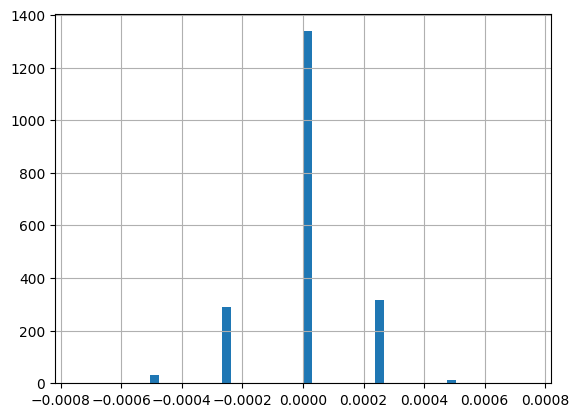

In [145]:
kelp_returns['pct_past_1'].hist(bins=50)

returns are within very narrow range, should def look into classification!

In [157]:
kelp_data[['bid_price_1', 'bid_price_2', 'bid_price_3']].describe()

,bid_price_1,bid_price_2,bid_price_3
count,2000.000000,382.000000,33.000000
mean,2017.678500,2017.455497,2016.727273
std,3.642633,3.637348,3.859021
min,2009.000000,2010.000000,2010.000000
25%,2015.000000,2014.000000,2013.000000
50%,2018.000000,2018.000000,2017.000000
75%,2020.000000,2020.000000,2019.000000
max,2028.000000,2026.000000,2025.000000


In [158]:
kelp_data[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].describe()

,bid_volume_1,bid_volume_2,bid_volume_3
count,2000.000000,382.000000,33.000000
mean,21.908000,24.034031,24.484848
std,9.961835,7.156400,3.589231
min,1.000000,1.000000,20.000000
25%,21.000000,22.000000,21.000000
50%,25.000000,26.000000,24.000000
75%,29.000000,29.000000,27.000000
max,40.000000,35.000000,32.000000


In [160]:
kelp_data[['ask_price_1', 'ask_price_2', 'ask_price_3']].describe()

,ask_price_1,ask_price_2,ask_price_3
count,2000.000000,483.000000,46.000000
mean,2020.425500,2020.865424,2021.217391
std,3.641164,3.690363,3.699328
min,2012.000000,2014.000000,2016.000000
25%,2017.000000,2018.000000,2018.000000
50%,2020.000000,2021.000000,2022.000000
75%,2023.000000,2023.000000,2023.750000
max,2029.000000,2029.000000,2028.000000


In [161]:
kelp_data[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].describe()

,ask_volume_1,ask_volume_2,ask_volume_3
count,2000.000000,483.000000,46.000000
mean,20.575500,23.672878,24.152174
std,10.050065,7.515726,6.827941
min,1.000000,1.000000,2.000000
25%,20.000000,22.000000,22.250000
50%,24.000000,25.000000,25.000000
75%,28.000000,28.000000,28.750000
max,32.000000,32.000000,32.000000


In [168]:
kelp_data[['bid_price_1', 'bid_price_2', 'bid_price_3']].idxmax(axis=1).value_counts()
kelp_data[['ask_price_1', 'ask_price_2', 'ask_price_3']].idxmin(axis=1).value_counts()

ask_price_1    2000
Name: count, dtype: int64